In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

%matplotlib inline

In [2]:
# let's have a look at our data at hand

iaq_df = pd.read_csv('data.csv',encoding="ISO-8859-1")

iaq_df.head()


,stn_code,sampling_date,state,location,agency,type,so2,no2,rspm,spm,location_monitoring_station,pm2_5,date
0,150,February - M021990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",4.8,17.4,NaN,NaN,NaN,NaN,1990-02-01
1,151,February - M021990,Andhra Pradesh,Hyderabad,NaN,Industrial Area,3.1,7.0,NaN,NaN,NaN,NaN,1990-02-01
2,152,February - M021990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",6.2,28.5,NaN,NaN,NaN,NaN,1990-02-01
3,150,March - M031990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",6.3,14.7,NaN,NaN,NaN,NaN,1990-03-01
4,151,March - M031990,Andhra Pradesh,Hyderabad,NaN,Industrial Area,4.7,7.5,NaN,NaN,NaN,NaN,1990-03-01


In [3]:
# checking basic stats of our features

iaq_df.describe()

,so2,no2,rspm,spm,pm2_5
count,401096.000000,419509.000000,395520.000000,198355.000000,9314.000000
mean,10.829414,25.809623,108.832784,220.783480,40.791467
std,11.177187,18.503086,74.872430,151.395457,30.832525
min,0.000000,0.000000,0.000000,0.000000,3.000000
25%,5.000000,14.000000,56.000000,111.000000,24.000000
50%,8.000000,22.000000,90.000000,187.000000,32.000000
75%,13.700000,32.200000,142.000000,296.000000,46.000000
max,909.000000,876.000000,6307.033333,3380.000000,504.000000


Text(0.5, 0, 'Features')

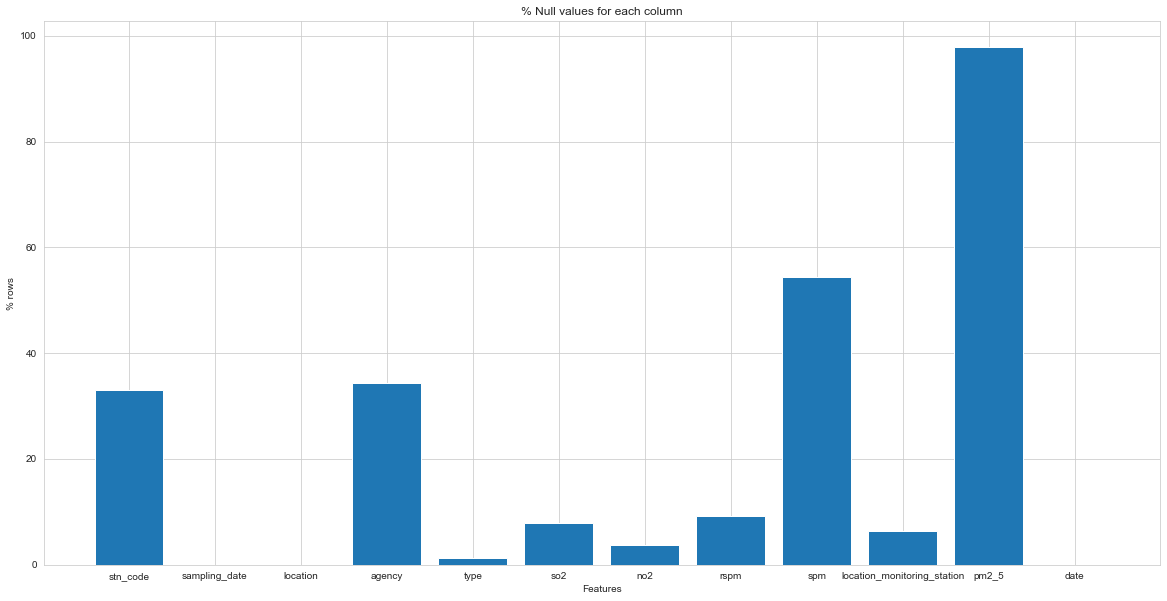

In [4]:
# looking at head we can see a lot of columns having null data for a few features
# let's try and visualize it

nan_cols = iaq_df.columns[iaq_df.isnull().any()]

nan_counts = iaq_df[nan_cols].isnull().sum()

plt.figure(figsize=(20,10))
plt.bar(nan_cols,(100*nan_counts/iaq_df.shape[0]))
plt.title('% Null values for each column')
plt.ylabel('% rows')
plt.xlabel('Features')

In [5]:
iaq_df.describe()['so2'].mean()


50256.71332514737

In [6]:
print(iaq_df.shape)

iaq_df.info()

(435742, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435742 entries, 0 to 435741
Data columns (total 13 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   stn_code                     291665 non-null  object 
 1   sampling_date                435739 non-null  object 
 2   state                        435742 non-null  object 
 3   location                     435739 non-null  object 
 4   agency                       286261 non-null  object 
 5   type                         430349 non-null  object 
 6   so2                          401096 non-null  float64
 7   no2                          419509 non-null  float64
 8   rspm                         395520 non-null  float64
 9   spm                          198355 non-null  float64
 10  location_monitoring_station  408251 non-null  object 
 11  pm2_5                        9314 non-null    float64
 12  date                         435735 non-null 

## From the above observations we can infer that :
1. We have a total of 435742 data points with 13 features
2. A lot of our data is null for almost all of the features
3. pm2_5 feature in given data is of no use to us as most of it is null
4. we can perform imputation on features ['so2','no2','rspm','spm'] as these are float64 values while the rest are object types

# Feature Engineering and Preprocessing :

In [21]:
# let's drop rows which will have 7 or more feature values as null in our data

iaq_df.dropna(thresh=7,inplace=True)
iaq_df.drop('pm2_5',inplace=True,axis=1)
print('shape of our data after dropping nan rows with threshold as 7/13 ===> '+str(iaq_df.shape))

shape of our data after dropping nan rows with threshold as 7/13 ===> (434064, 12)


 as we can see we have **dropped approximately 20k data points** in the above step

**Let's add a few more features that can be calculated from our existing features :**
1. so2 Individual pollutant index
2. no2 Individual pollutant index
3. rspm Individual pollutant index
4. spm Individual pollutant index
5. AQI (Air quality Index)

In [8]:
# feature calculation referenced from https://www.kaggle.com/anbarivan/indian-air-quality-analysis-prediction-using-ml notebook

def calculate_si(so2):
    si=0
    if (so2<=40):
     si= so2*(50/40)
    if (so2>40 and so2<=80):
     si= 50+(so2-40)*(50/40)
    if (so2>80 and so2<=380):
     si= 100+(so2-80)*(100/300)
    if (so2>380 and so2<=800):
     si= 200+(so2-380)*(100/800)
    if (so2>800 and so2<=1600):
     si= 300+(so2-800)*(100/800)
    if (so2>1600):
     si= 400+(so2-1600)*(100/800)
    return si

def calculate_ni(no2):
    ni=0
    if(no2<=40):
     ni= no2*50/40
    elif(no2>40 and no2<=80):
     ni= 50+(no2-14)*(50/40)
    elif(no2>80 and no2<=180):
     ni= 100+(no2-80)*(100/100)
    elif(no2>180 and no2<=280):
     ni= 200+(no2-180)*(100/100)
    elif(no2>280 and no2<=400):
     ni= 300+(no2-280)*(100/120)
    else:
     ni= 400+(no2-400)*(100/120)
    return ni

def calculate_(rspm):
    rpi=0
    if(rpi<=30):
     rpi=rpi*50/30
    elif(rpi>30 and rpi<=60):
     rpi=50+(rpi-30)*50/30
    elif(rpi>60 and rpi<=90):
     rpi=100+(rpi-60)*100/30
    elif(rpi>90 and rpi<=120):
     rpi=200+(rpi-90)*100/30
    elif(rpi>120 and rpi<=250):
     rpi=300+(rpi-120)*(100/130)
    else:
     rpi=400+(rpi-250)*(100/130)
    return rpi

def calculate_spi(spm):
    spi=0
    if(spm<=50):
     spi=spm
    if(spm<50 and spm<=100):
     spi=spm
    elif(spm>100 and spm<=250):
     spi= 100+(spm-100)*(100/150)
    elif(spm>250 and spm<=350):
     spi=200+(spm-250)
    elif(spm>350 and spm<=450):
     spi=300+(spm-350)*(100/80)
    else:
     spi=400+(spm-430)*(100/80)
    return spi

def calculate_aqi(si,ni,spi,rpi):
    aqi=0
    if(si>ni and si>spi and si>rpi):
     aqi=si
    if(spi>si and spi>ni and spi>rpi):
     aqi=spi
    if(ni>si and ni>spi and ni>rpi):
     aqi=ni
    if(rpi>si and rpi>ni and rpi>spi):
     aqi=rpi
    return aqi

But as a lot of our dependant features have null values it is better to impute them before calculating our new engineered features

In [26]:
# let's impute our data
# since ['so2','no2','rspm','spm'] are element levels I am going to replace nan values with median values for respective features
    
a=['so2','no2','rspm','spm']
b= iaq_df.median(axis = 0, skipna = True)

df_medians = dict(zip(a,b))
df_medians

for col in a:
    iaq_df[col].fillna(df_medians.get(col),inplace=True)
    
iaq_df.columns[iaq_df.isnull().any()]

Index(['stn_code', 'agency', 'type', 'location_monitoring_station', 'date'], dtype='object')

In [27]:
# replacing object type data with an empty string

iaq_df.fillna('', inplace=True)
iaq_df.columns[iaq_df.isnull().any()]

Index([], dtype='object')

In [29]:
# now let's calculate our new features

iaq_df['si'] = iaq_df['so2'].apply(calculate_si)

iaq_df['ni'] = iaq_df['no2'].apply(calculate_ni)

iaq_df['rpi'] = iaq_df['rspm'].apply(calculate_)

iaq_df['spi'] = iaq_df['spm'].apply(calculate_spi)

iaq_df['AQI']=iaq_df.apply(lambda x:calculate_aqi(x['si'],x['ni'],x['spi'],x['rpi']),axis=1)

iaq_df.head()

,stn_code,sampling_date,state,location,agency,type,so2,no2,rspm,spm,location_monitoring_station,date,si,ni,rpi,spi,AQI
0,150,February - M021990,Andhra Pradesh,Hyderabad,,"Residential, Rural and other Areas",4.8,17.4,90.0,187.0,,1990-02-01,6.000,21.750,0.0,158.0,158.0
1,151,February - M021990,Andhra Pradesh,Hyderabad,,Industrial Area,3.1,7.0,90.0,187.0,,1990-02-01,3.875,8.750,0.0,158.0,158.0
2,152,February - M021990,Andhra Pradesh,Hyderabad,,"Residential, Rural and other Areas",6.2,28.5,90.0,187.0,,1990-02-01,7.750,35.625,0.0,158.0,158.0
3,150,March - M031990,Andhra Pradesh,Hyderabad,,"Residential, Rural and other Areas",6.3,14.7,90.0,187.0,,1990-03-01,7.875,18.375,0.0,158.0,158.0
4,151,March - M031990,Andhra Pradesh,Hyderabad,,Industrial Area,4.7,7.5,90.0,187.0,,1990-03-01,5.875,9.375,0.0,158.0,158.0


In [43]:
# dropping a few more features that don't seem useful and splitting the date feature into year,month and day features

iaq_df.drop(iaq_df.columns,axis=0,inplace=True)

iaq_df['date'] = pd.to_datetime(iaq_df['date'],format='%Y-%m-%d')

iaq_df["day"]   = iaq_df['date'].map(lambda x: x.day)
iaq_df["month"] = iaq_df['date'].map(lambda x: x.month)
iaq_df["year"]  = iaq_df['date'].map(lambda x: x.year)

iaq_df.head()

,state,location,type,so2,no2,rspm,spm,date,si,ni,rpi,spi,AQI,day,month,year
0,Andhra Pradesh,Hyderabad,"Residential, Rural and other Areas",4.8,17.4,90.0,187.0,1990-02-01,6.000,21.750,0.0,158.0,158.0,1.0,2.0,1990.0
1,Andhra Pradesh,Hyderabad,Industrial Area,3.1,7.0,90.0,187.0,1990-02-01,3.875,8.750,0.0,158.0,158.0,1.0,2.0,1990.0
2,Andhra Pradesh,Hyderabad,"Residential, Rural and other Areas",6.2,28.5,90.0,187.0,1990-02-01,7.750,35.625,0.0,158.0,158.0,1.0,2.0,1990.0
3,Andhra Pradesh,Hyderabad,"Residential, Rural and other Areas",6.3,14.7,90.0,187.0,1990-03-01,7.875,18.375,0.0,158.0,158.0,1.0,3.0,1990.0
4,Andhra Pradesh,Hyderabad,Industrial Area,4.7,7.5,90.0,187.0,1990-03-01,5.875,9.375,0.0,158.0,158.0,1.0,3.0,1990.0


In [48]:
iaq_df.head()

,state,location,type,so2,no2,rspm,spm,date,si,ni,rpi,spi,AQI,day,month,year
0,Andhra Pradesh,Hyderabad,"Residential, Rural and other Areas",4.8,17.4,90.0,187.0,1990-02-01,6.000,21.750,0.0,158.0,158.0,1.0,2.0,1990.0
1,Andhra Pradesh,Hyderabad,Industrial Area,3.1,7.0,90.0,187.0,1990-02-01,3.875,8.750,0.0,158.0,158.0,1.0,2.0,1990.0
2,Andhra Pradesh,Hyderabad,"Residential, Rural and other Areas",6.2,28.5,90.0,187.0,1990-02-01,7.750,35.625,0.0,158.0,158.0,1.0,2.0,1990.0
3,Andhra Pradesh,Hyderabad,"Residential, Rural and other Areas",6.3,14.7,90.0,187.0,1990-03-01,7.875,18.375,0.0,158.0,158.0,1.0,3.0,1990.0
4,Andhra Pradesh,Hyderabad,Industrial Area,4.7,7.5,90.0,187.0,1990-03-01,5.875,9.375,0.0,158.0,158.0,1.0,3.0,1990.0


In [50]:
iaq_df['type'].value_counts()

Residential, Rural and other Areas    179012
Industrial Area                        96091
Residential and others                 85918
Industrial Areas                       51133
Sensitive Area                          8980
Sensitive Areas                         5434
                                        5306
RIRUO                                   1304
Sensitive                                495
Industrial                               233
Residential                              158
Name: type, dtype: int64

In [56]:
iaq_df['type'] = iaq_df['type'].str.replace(' ','_')
iaq_df['type'] = iaq_df['type'].str.replace('and','_')
iaq_df['type'] = iaq_df['type'].str.replace(',','_')
iaq_df['type'] = iaq_df['type'].str.replace('__','_')
iaq_df['type'] = iaq_df['type'].str.replace('_Areas','')
iaq_df['type'] = iaq_df['type'].str.replace('_Area','')

iaq_df['type'].value_counts()

Residential_Rural_other    179012
Industrial                 147457
Residential_others          85918
Sensitive                   14909
                             5306
RIRUO                        1304
Residential                   158
Name: type, dtype: int64

In [58]:
iaq_df['location'].value_counts()

Guwahati            9984
Hyderabad           9652
Delhi               8549
Chandigarh          8519
Jaipur              7849
                    ... 
SANAND                23
Noida, Ghaziabad      21
Khajuraho             16
Gangtok                1
Dharuhera              1
Name: location, Length: 304, dtype: int64

In [59]:
iaq_df['location'] = iaq_df['location'].str.replace(',','_')
iaq_df['location'] = iaq_df['location'].str.replace(' ','_')
iaq_df['location'] = iaq_df['location'].str.replace('__','_')

iaq_df['location'].value_counts()

Guwahati           9984
Hyderabad          9652
Delhi              8549
Chandigarh         8519
Jaipur             7849
                   ... 
SANAND               23
Noida_Ghaziabad      21
Khajuraho            16
Gangtok               1
Dharuhera             1
Name: location, Length: 304, dtype: int64

In [63]:
iaq_df.head()

,state,location,type,so2,no2,rspm,spm,si,ni,rpi,spi,AQI,day,month,year
0,Andhra Pradesh,Hyderabad,Residential_Rural_other,4.8,17.4,90.0,187.0,6.000,21.750,0.0,158.0,158.0,1.0,2.0,1990.0
1,Andhra Pradesh,Hyderabad,Industrial,3.1,7.0,90.0,187.0,3.875,8.750,0.0,158.0,158.0,1.0,2.0,1990.0
2,Andhra Pradesh,Hyderabad,Residential_Rural_other,6.2,28.5,90.0,187.0,7.750,35.625,0.0,158.0,158.0,1.0,2.0,1990.0
3,Andhra Pradesh,Hyderabad,Residential_Rural_other,6.3,14.7,90.0,187.0,7.875,18.375,0.0,158.0,158.0,1.0,3.0,1990.0
4,Andhra Pradesh,Hyderabad,Industrial,4.7,7.5,90.0,187.0,5.875,9.375,0.0,158.0,158.0,1.0,3.0,1990.0


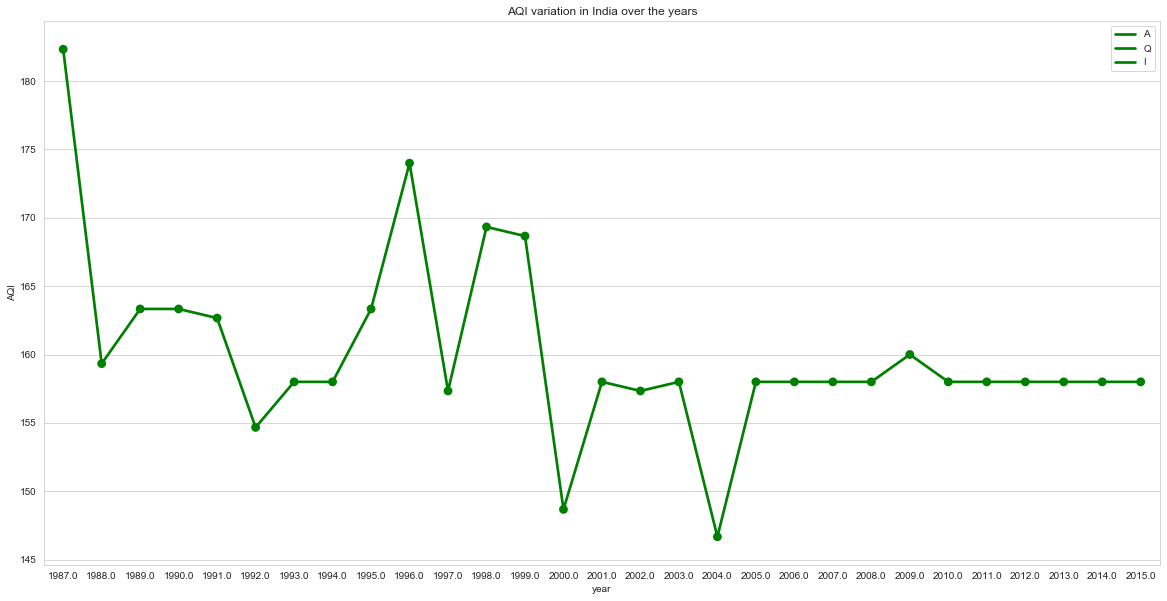

In [80]:
# let's look at some plots to get a few insights from our processed data

# AQI over the years

plot_data = iaq_df[['AQI','year','state']].groupby(["year"]).median().reset_index().sort_values(by='year',ascending=False)

plt.figure(figsize=(20,10))
sns.pointplot(x=plot_data['year'],y=plot_data['AQI'],color='g')
plt.title('AQI variation in India over the years')

Text(0.5, 1.0, 'Statewise AQI plot')

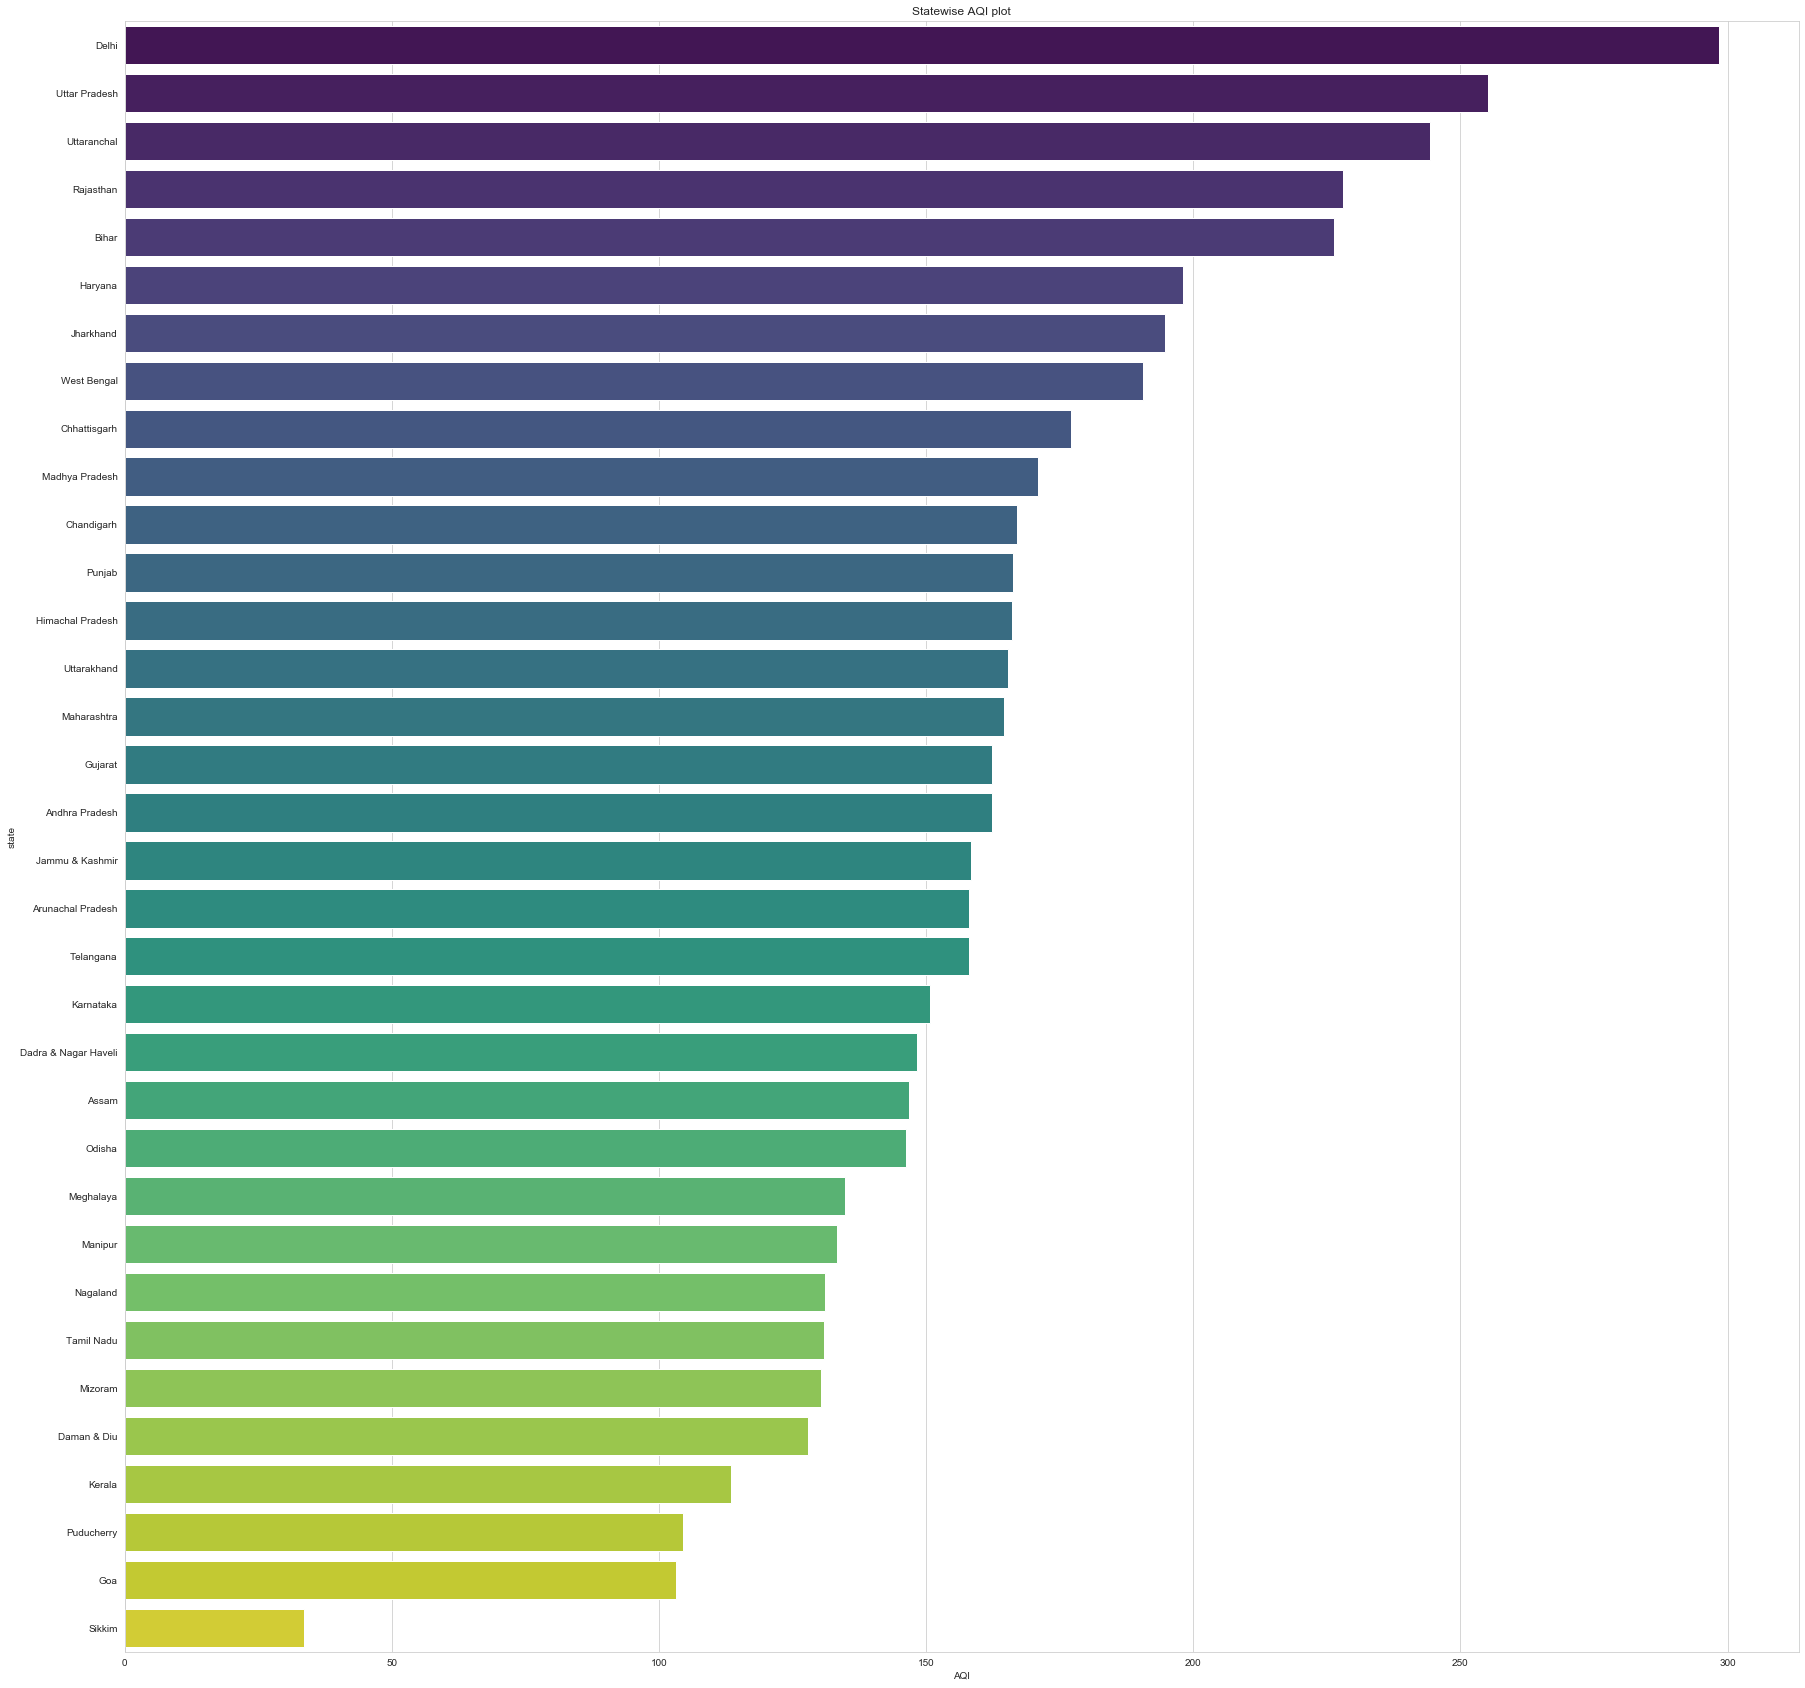

In [104]:
plot_data = iaq_df.groupby(['state'])['AQI'].agg('mean').reset_index().sort_values(by='AQI',ascending=False)

plt.figure(figsize=(30,30))
sns.barplot(plot_data['AQI'],plot_data['state'],palette='viridis')
plt.title('Statewise AQI plot')

**From above plots we can infer :**
1. AQI has been the highest in year 1987 as per the recorded data
2. Delhi has experienced the worst AQI over the years (the situation is still prevalent in 2021)

Text(0.5, 1.0, 'Area type wise AQI plot')

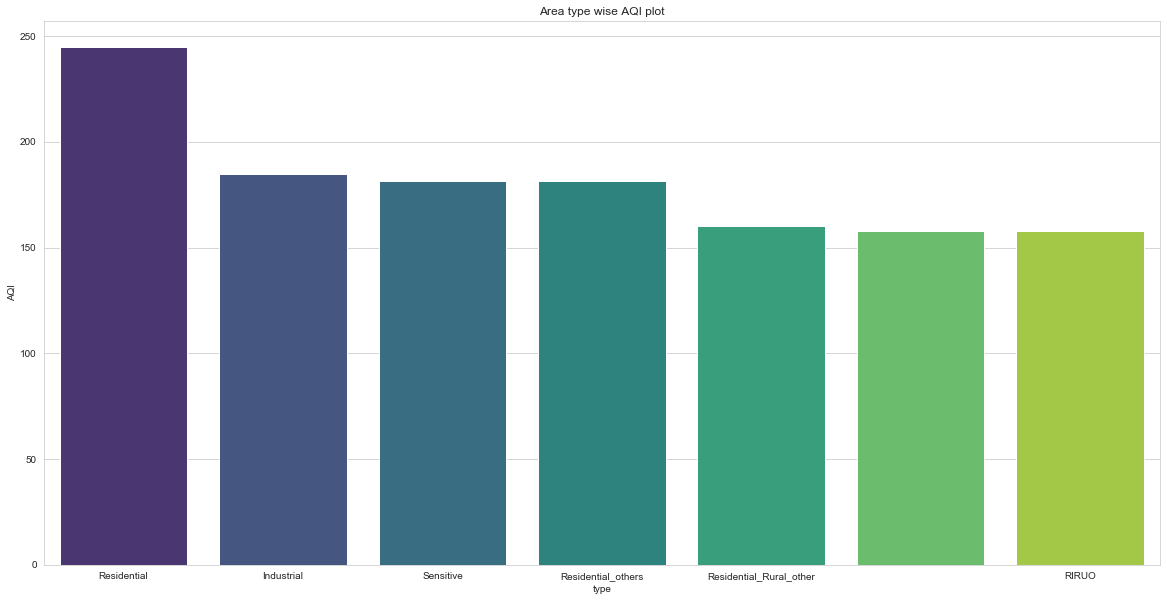

In [108]:
plot_data = iaq_df.groupby(['type'])['AQI'].agg('mean').reset_index().sort_values(by='AQI',ascending=False)

plt.figure(figsize=(20,10))
sns.barplot(plot_data['type'],plot_data['AQI'],palette='viridis')
plt.title('Area type wise AQI plot')

Text(0.5, 1.0, 'location wise AQI plot')

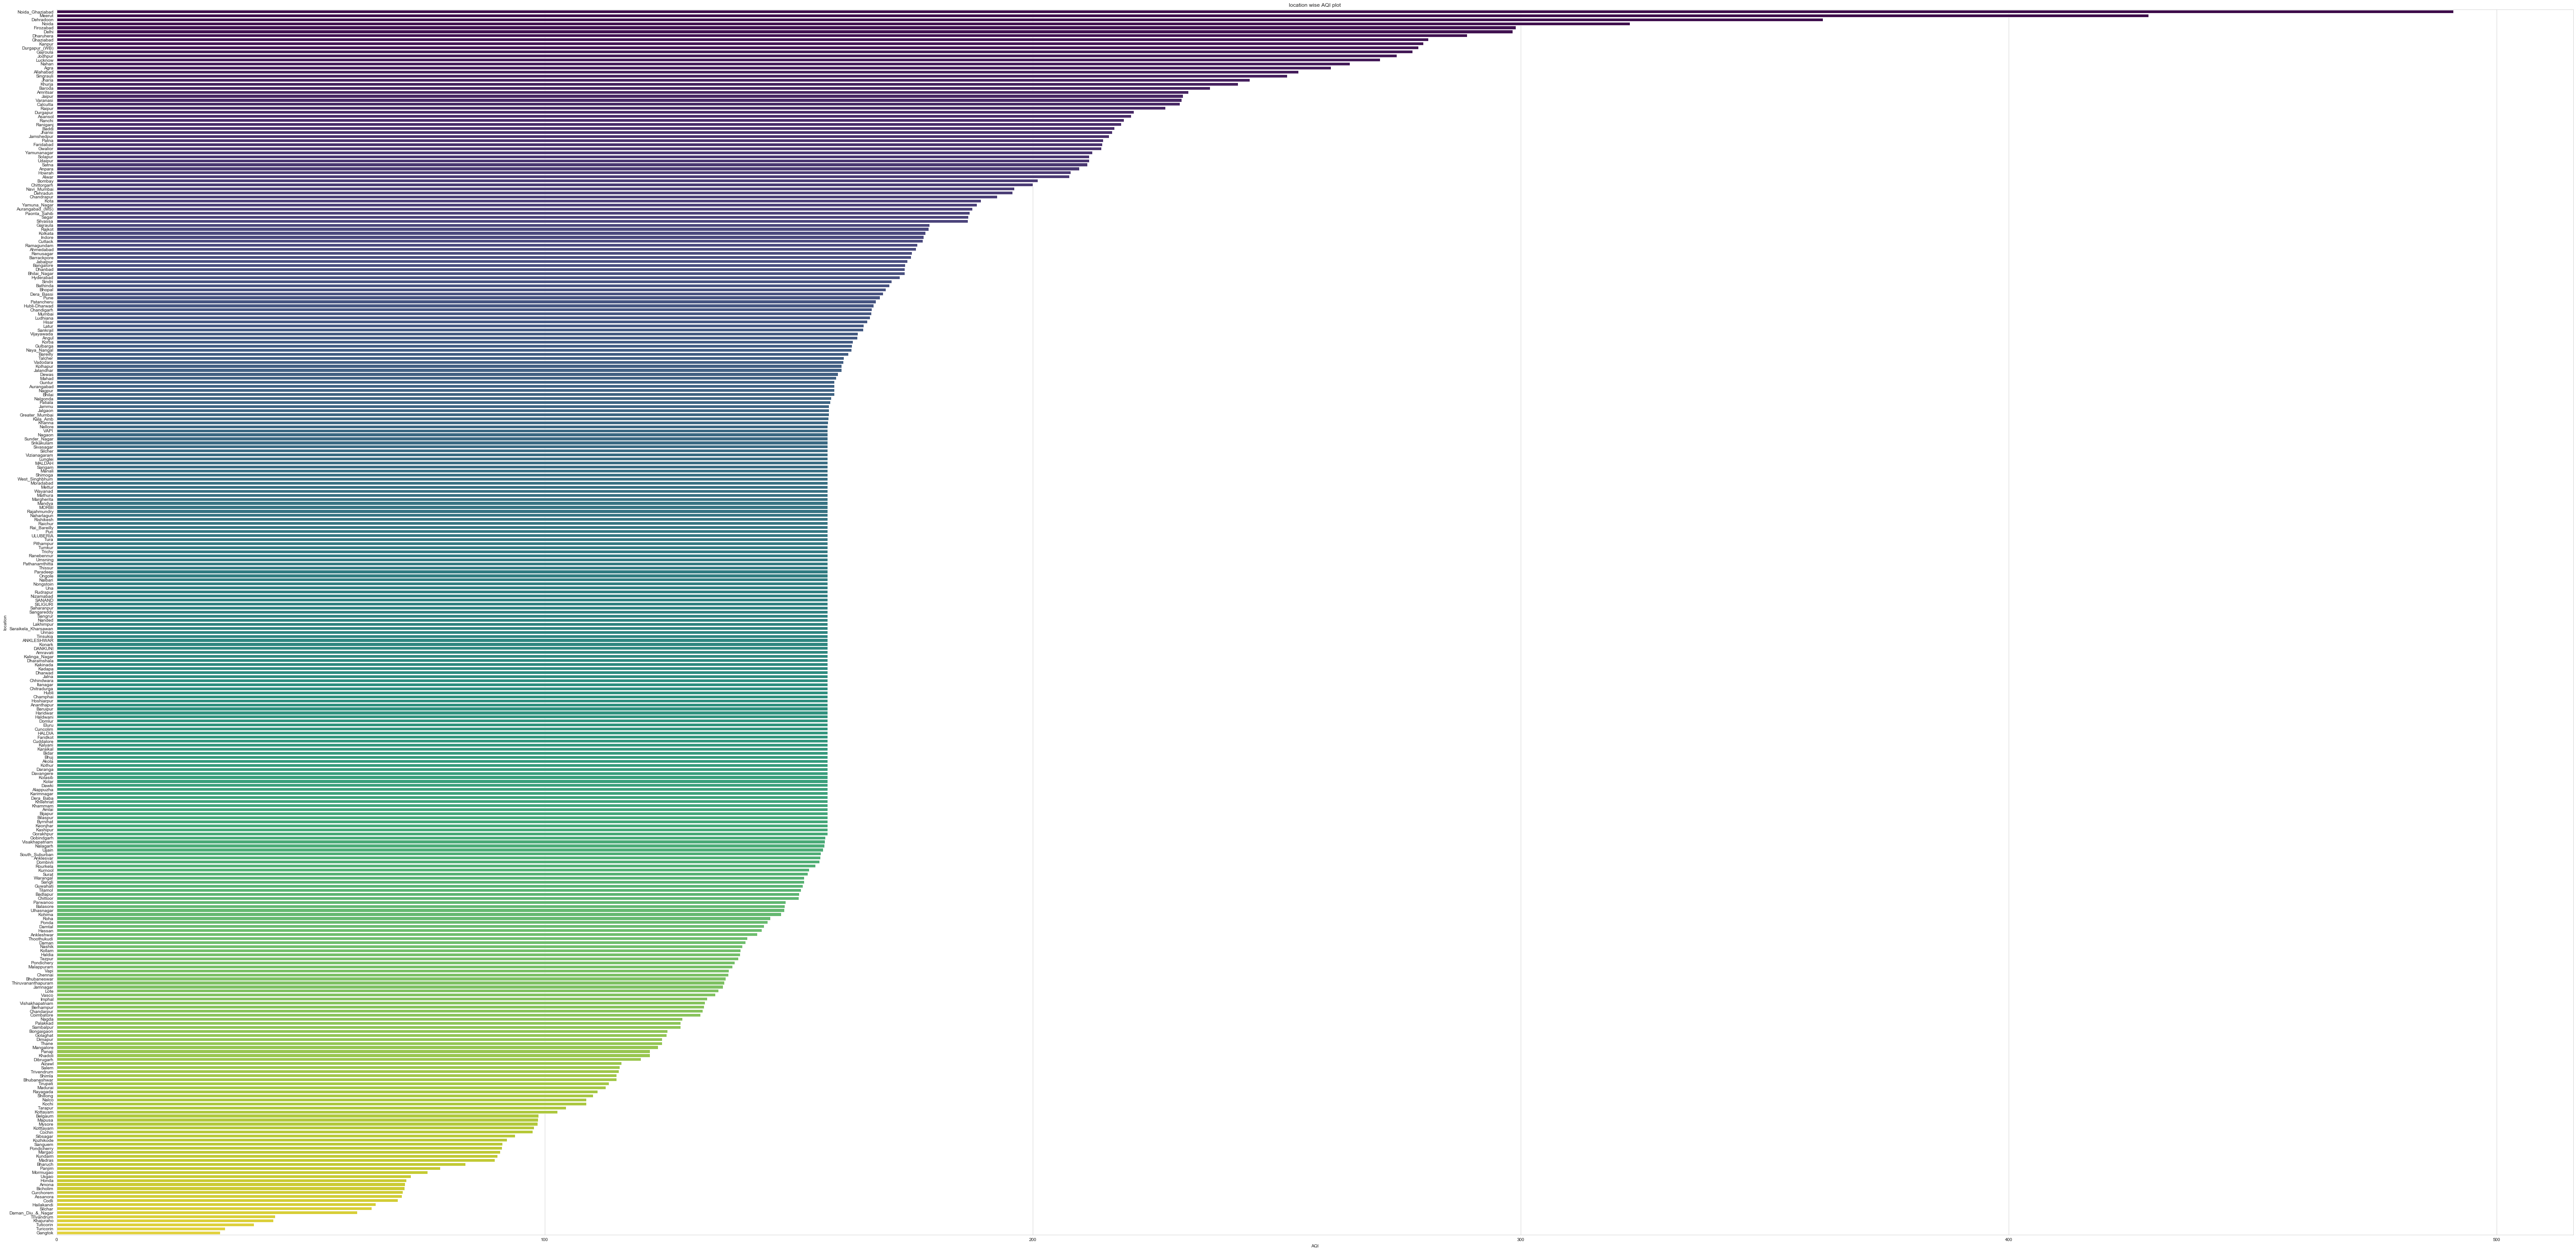

In [110]:
plot_data = iaq_df.groupby(['location'])['AQI'].agg('mean').reset_index().sort_values(by='AQI',ascending=False)

plt.figure(figsize=(100,50))
sns.barplot(plot_data['AQI'],plot_data['location'],palette='viridis')
plt.title('location wise AQI plot')

**From the above plots we can infer :**
1. Surprisingly residential areas had the worst AQI over the years
2. Location wise plot is practically unreadable , we can rather select a state and view the location plot within it

Text(0.5, 1.0, 'location wise AQI plot for Andhra Pradesh')

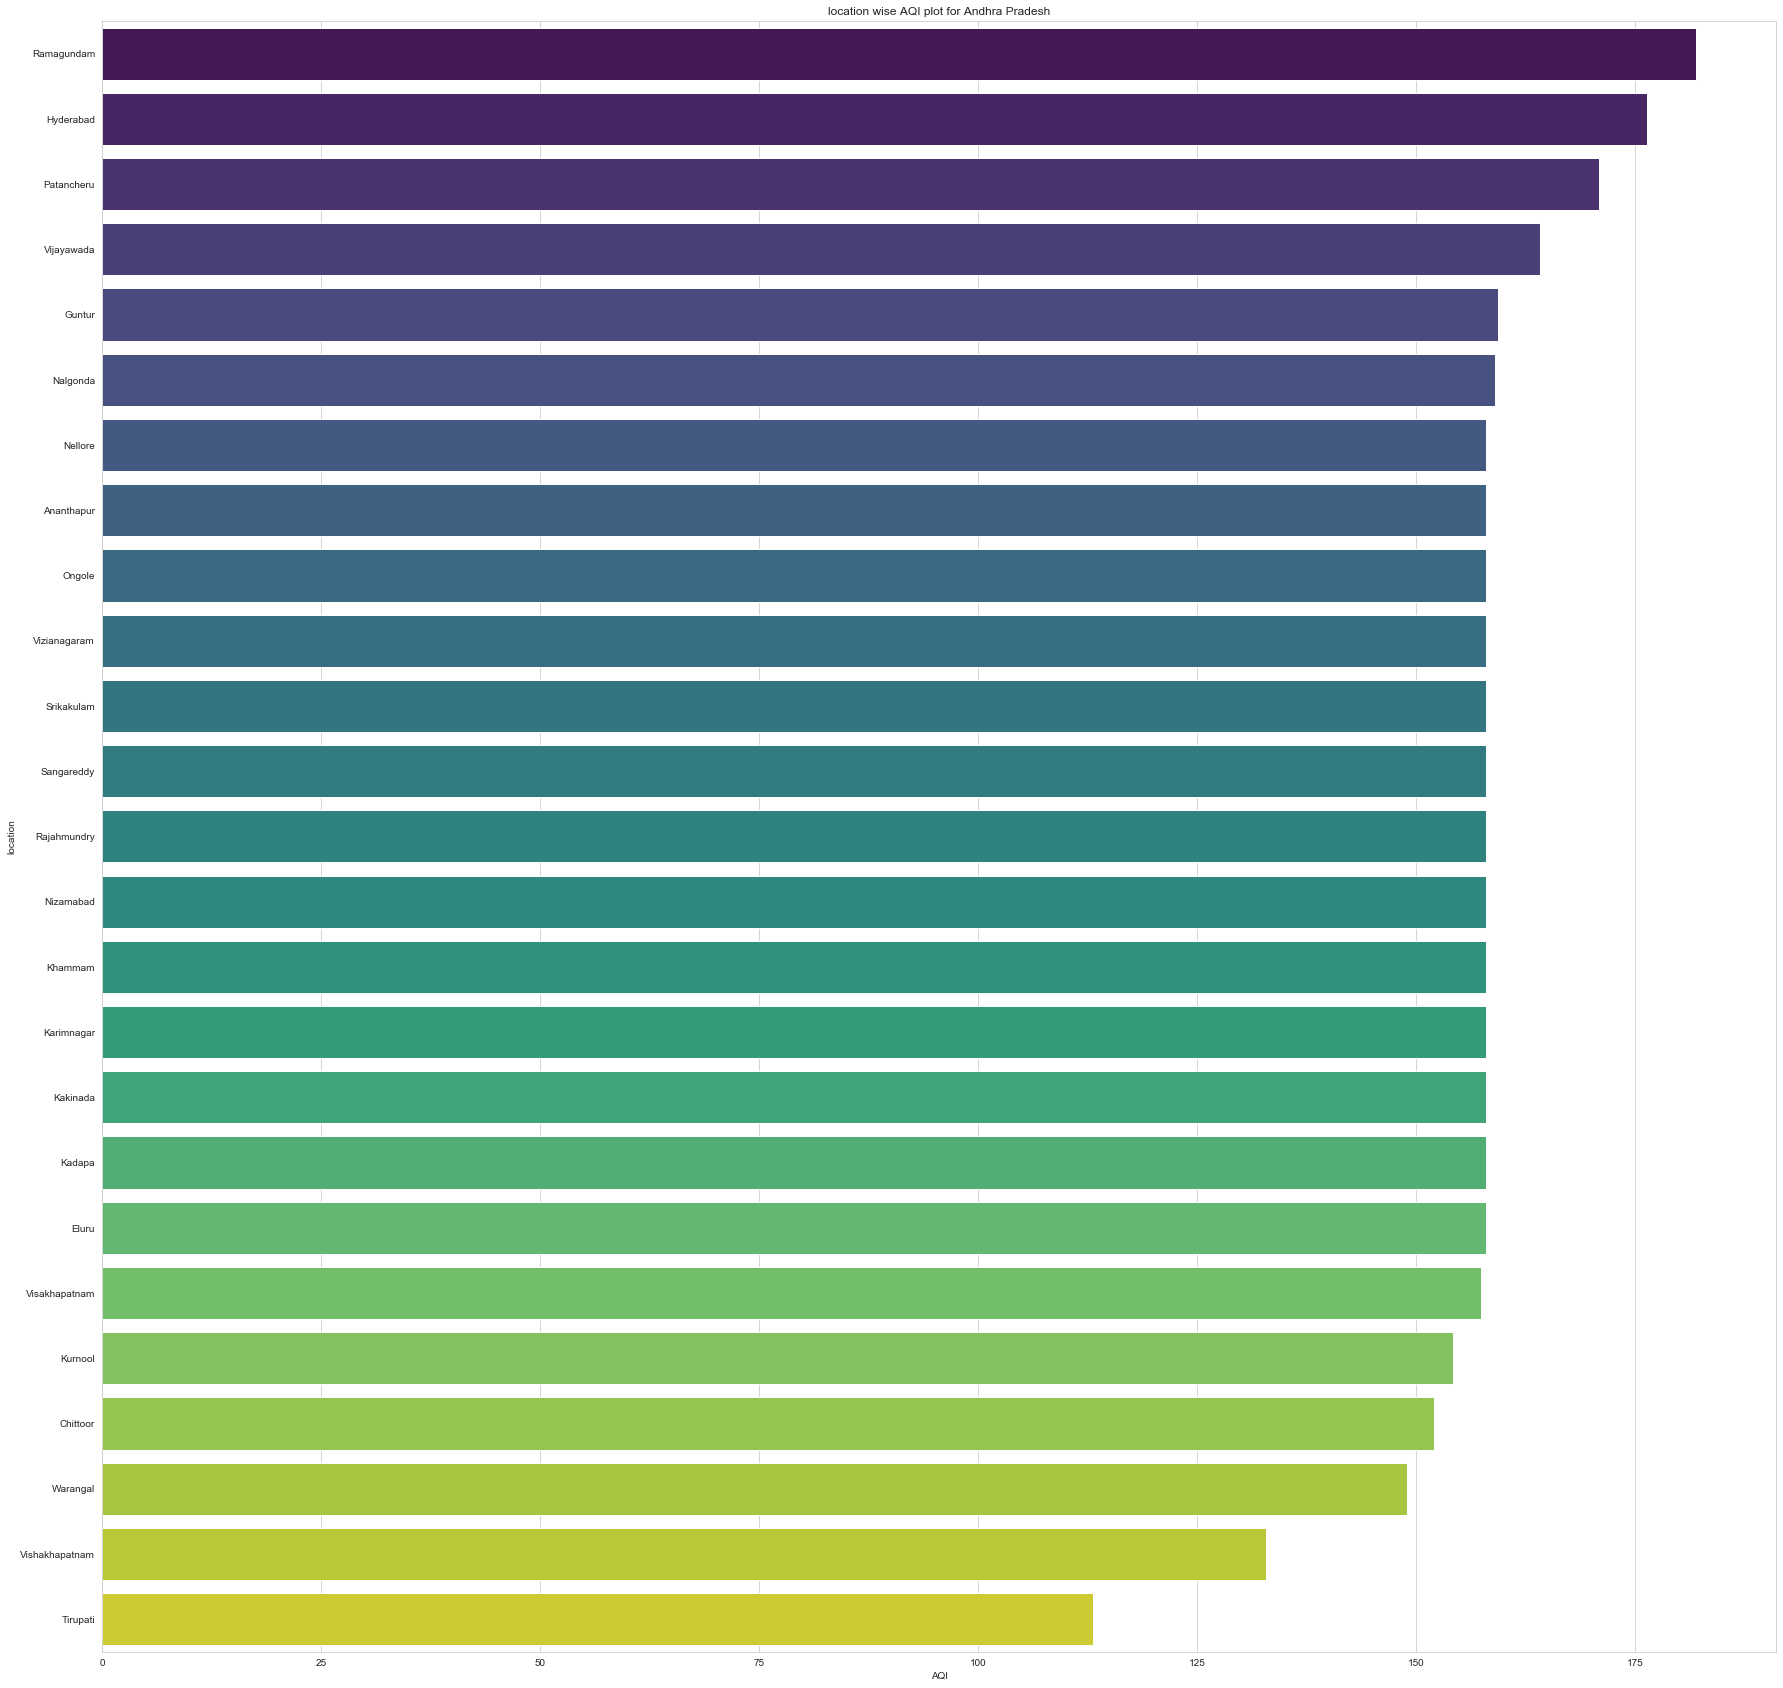

In [124]:
### plot_data = iaq_df[iaq_df['state']=='Andhra Pradesh']
plot_data = plot_data.groupby(['location'])['AQI'].agg('mean').reset_index().sort_values(by='AQI',ascending=False)

plt.figure(figsize=(30,30))
sns.barplot(plot_data['AQI'],plot_data['location'],palette='viridis')
plt.title('location wise AQI plot for Andhra Pradesh')

**Like this we can observe the most polluted location for a State, Ramagudam for Andhra Pradesh**